In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy

from spin import *
from trotter import *
import time

In [2]:
simulator_gpu = AerSimulator(method='statevector', device='GPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

['GPU']
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [47]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 8

QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)

H = QIMF.ham_xyz
print(H)

init = Statevector.from_label("101010101010")
t, dt, dt2 = 10.0, 0.1, 0.02
r = int(round(t / dt))
m = 5
print(r, m)

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j])]
100 5


In [48]:
from qiskit.synthesis import SuzukiTrotter

trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())
qc = QuantumCircuit(n)

trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())
circuit = QuantumCircuit(n)

In [ ]:
start_time = time.time()

for s in range(1, r+1):
  for ss in range (1, m+1):
    print("step:", ss)
    circuit.append(trotter_step_second_order, range(n))
    circuit = circuit.decompose(reps=2)
  circuit.save_statevector(label=f"sv2_{s}")

  qc.append(trotter_step_first_order, range(n))
  qc.save_statevector(label=f"sv_{s}")
  qc = qc.decompose(reps=2)
  print("pf1 step:", s)

res = simulator_gpu.run(transpile(qc, simulator_gpu), initial_statevector=init.data).result()
res2 = simulator_gpu.run(transpile(circuit, simulator_gpu), initial_statevector=init.data).result()
data = res.data(0)
data2 = res2.data(0)
better_states = [data2[f"sv2_{s}"] for s in range(1, r+1)]
states = [data[f"sv_{s}"] for s in range(1, r+1)]

total_time = time.time() - start_time
print("total time", total_time)

In [ ]:
entropy_list = []
entropy_list2 = []

for s in range(1, r+1):
    print(s)
    rdm1 = partial_trace(DensityMatrix(states[s-1]), [0])
    rdm2 = partial_trace(DensityMatrix(states[s-1]), [0, 1])
    rdm3 = partial_trace(DensityMatrix(states[s-1]), [0, 1, 2])
    rdm4 = partial_trace(DensityMatrix(states[s-1]), [0, 1, 2, 3])
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    # print(temp_entropy[0])

    rdm12 = partial_trace(DensityMatrix(better_states[s-1]), [0])
    rdm22 = partial_trace(DensityMatrix(better_states[s-1]), [0, 1])
    rdm32 = partial_trace(DensityMatrix(better_states[s-1]), [0, 1, 2])
    rdm42 = partial_trace(DensityMatrix(better_states[s-1]), [0, 1, 2, 3])
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    # print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

In [ ]:
trotter = []
for s in range(0, r):
  tro = np.linalg.norm(better_states[s] - states[s])
  print(tro)
  trotter.append(tro)

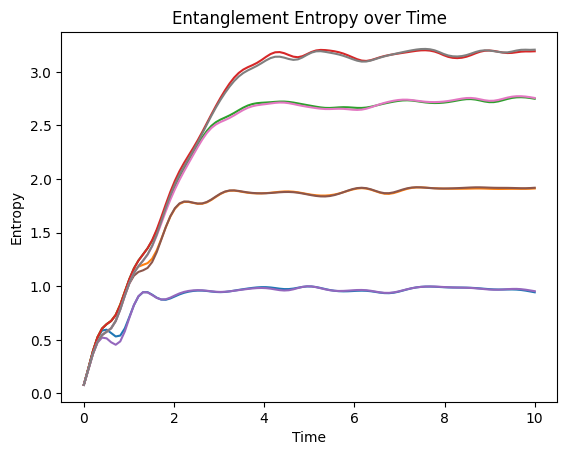

In [127]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

# Extract the first element of each sublist in entropy_list
entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]


# Extract the first element of each sublist in entropy_list2
entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

# Create the plot
plt.plot(times, entropy_values_1)
plt.plot(times, entropy_values_2)
plt.plot(times, entropy_values_3)
plt.plot(times, entropy_values_4)

plt.plot(times, entropy_values_12)
plt.plot(times, entropy_values_22)
plt.plot(times, entropy_values_32)
plt.plot(times, entropy_values_42)

plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entanglement Entropy over Time")
plt.show()

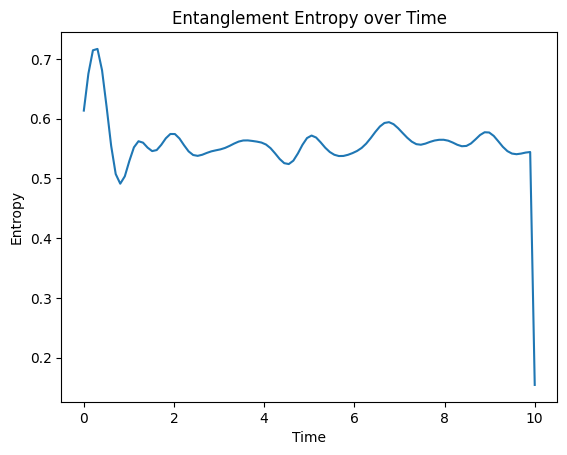

In [128]:
plt.plot(times, trotter)
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entanglement Entropy over Time")
plt.show()